# Sparse vs Dense classification

Note: By dense classification I mean that all model parameters are involved and estimated to a non-zero value. 

In the lecture, there were two pairs of methods that represented a dense and a sparse version of the same method.

    Naive Bayes/Nearest Centroids and Shrunken Centroids
    Logistic Regression and Sparse Logistic Regression 

The goal of this project is to determine for which types of data sparse and dense classification methods work better, respectively.

Consider the following topics

    Dimensionality of the dataset
    Sparsity of the predictors, i.e. to which extent are predictors affecting the response
    Noise in the response and/or the predictors: Are dense or sparse methods better if there is a lot of noise in the response? What is the impact of noise in the predictor variables on the performance of sparse or dense methods?

Either simulate sparse/dense data (e.g. by following the instructions here before transforming the linear model responses to binary classes with the logistic transform) or take real datasets that illustrate your arguments.

*It is probably easiest to stick to binary classification. Then simple measures like sensitivity and specificity or even the misclassification rate can be used to judge the performance of each method.

*If you simulate data, make sure to repeat the simulations multiple times to be able to quantify uncertainty in your performance estimates. If you use a real dataset, you can bootstrap the dataset to achieve "repeated simulations".

https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html#log

In [1]:
library(glmnet)
library(plyr)
library(corrplot)
#library(caret) # sensitivity, specificity --messes up glmnet graphing when it's loaded

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [70]:
breast_cancer<-read.csv("breast-cancer-Wisconsin.data", header=FALSE)
breast_cancer <-rename(breast_cancer, c("V1"="id", "V2"="thickness", "V3" = "uni_size", "V4" = "uni_shape", 
                       "V5" = "adhesion", "V6"="epi_size", "V7" = "bare_nuclei", 
                       "V8" = "bland_chroma", "V9"="normal_nuc", "V10"="mitosis", 
                       "V11" = "class"))

# bare nuclei was being read as a categorical variable
breast_cancer$bare_nuclei <-as.numeric(breast_cancer$bare_nuclei)

#logistic regression wants 0 and 1 instead of 2 and 4
breast_cancer$class <- as.character(breast_cancer$class)
breast_cancer$class[breast_cancer$class == "2"] <- "0"
breast_cancer$class[breast_cancer$class == "4"] <- "1"
breast_cancer$class <- as.numeric(breast_cancer$class)

#summary(breast_cancer)
#dim(breast_cancer)
#head(breast_cancer)

# for glmnet
x_matrix <- model.matrix( ~ thickness + uni_size + uni_shape + adhesion + epi_size 
                  + bare_nuclei + bland_chroma + normal_nuc + mitosis - 1, breast_cancer)
y <- breast_cancer$clas
#any(is.na(X)) # there are no nas

[1] 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1
 [38] 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1
 [75] 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0
[112] 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
[149] 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
[186] 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1
[223] 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0
[260] 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1
[297] 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0
[334] 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0
[371] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
[408] 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
[445] 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
[482] 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0
[519] 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
[556] 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1
[593] 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
[630] 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
[667] 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

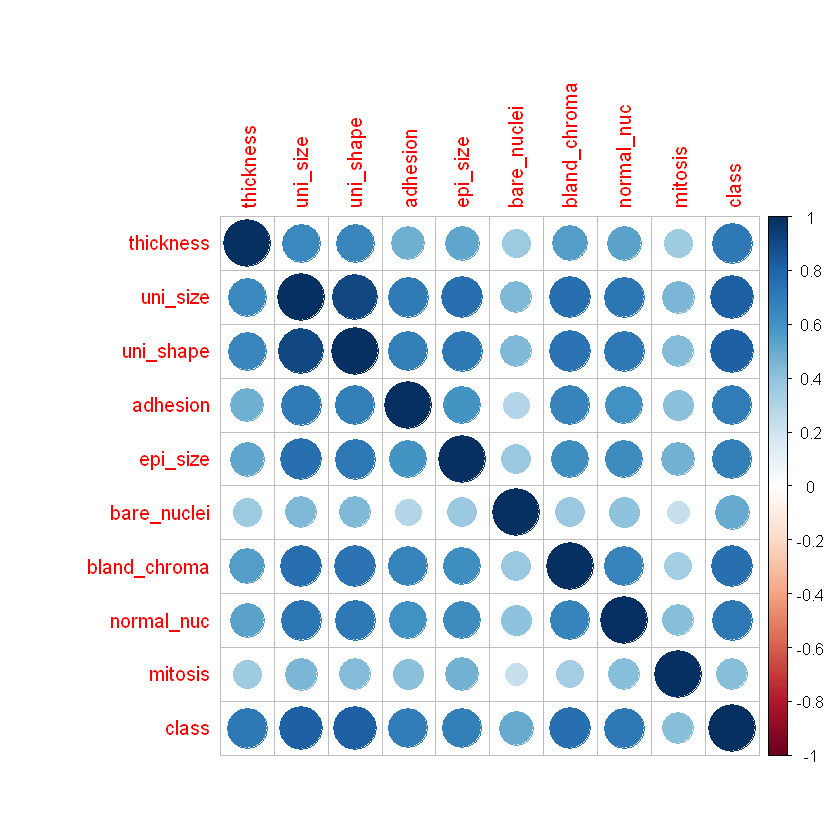

In [64]:
correlations <- cor(breast_cancer[,-1])
corrplot(correlations, method="circle")

In [5]:
# Logistic Regression
logistic_bc <- glm(class ~ thickness + uni_size + adhesion + epi_size + bare_nuclei 
                + bland_chroma + normal_nuc + mitosis, data = breast_cancer, 
                family=binomial(link='logit'))

#summary(logistic_bc)

anova(logistic_bc, test="Chisq")

threshold = 0.5
fitted.results <- predict(logistic_bc,type='response')
fitted.results <- ifelse(fitted.results > threshold,1,0)

misClassificError <- mean(fitted.results != breast_cancer$class)
misClassificError

predicted_values <- ifelse(predict(logistic_bc,type="response") > threshold,1,0)
actual_values <- breast_cancer$class
conf_matrix <- table(predicted_values,actual_values)
conf_matrix


#sensitivity(conf_matrix)
#specificity(conf_matrix)

Df Deviance   Resid. Df Resid. Dev Pr(>Chi)    
NULL         NA         NA 698       900.5274             NA
thickness     1 436.473481 697       464.0540   6.338108e-97
uni_size      1 251.747248 696       212.3067   1.080262e-56
adhesion      1  22.413970 695       189.8927   2.197697e-06
epi_size      1   9.437713 694       180.4550   2.125684e-03
bare_nuclei   1  15.481715 693       164.9733   8.330725e-05
bland_chroma  1  20.770283 692       144.2030   5.178023e-06
normal_nuc    1   1.523235 691       142.6798   2.171307e-01
mitosis       1   3.606688 690       139.0731   5.754763e-02

[1] 0.04291845

                actual_values
predicted_values   0   1
               0 444  16
               1  14 225

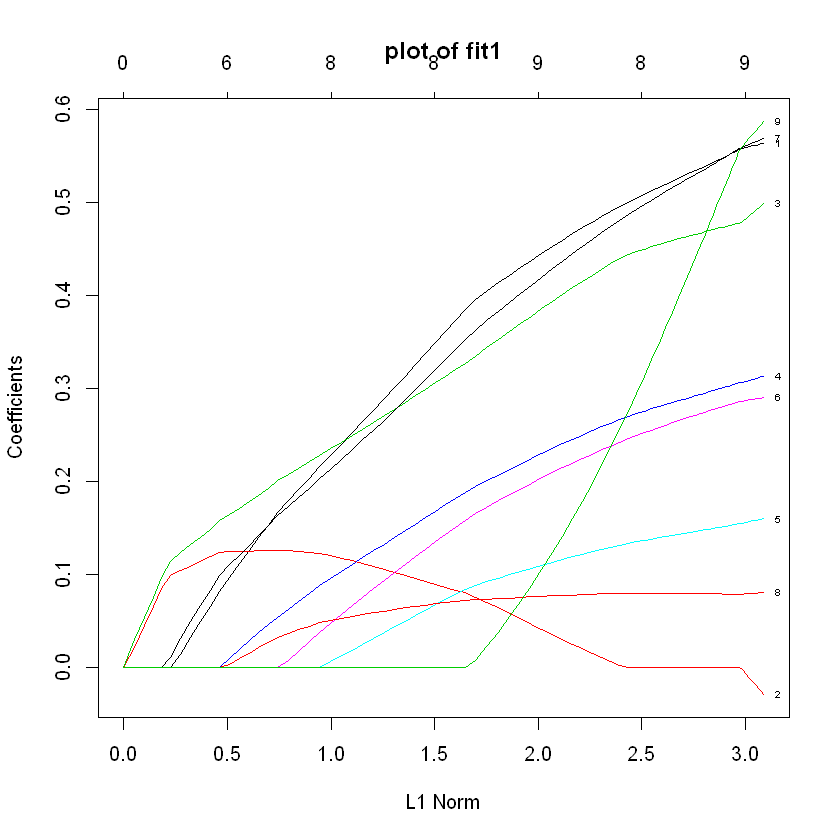

In [101]:
# The input must be a matrix, not a data frame
fit = glmnet(x_matrix, y, family="binomial")
plot(fit, main="plot of fit1", label=TRUE)
#coef(fit)

In [102]:
cvfit = cv.glmnet(x_matrix, y, family = "binomial", type.measure = "class")
# find best lambda as measured by misclassification error
cvfit

$lambda
 [1] 0.3892358635 0.3546572222 0.3231504521 0.2944426566 0.2682851825
 [6] 0.2444514664 0.2227350719 0.2029479020 0.1849185697 0.1684909137
[11] 0.1535226453 0.1398841166 0.1274571972 0.1161342511 0.1058172044
[16] 0.0964166956 0.0878513021 0.0800468345 0.0729356944 0.0664562883
[21] 0.0605524948 0.0551731781 0.0502717450 0.0458057417 0.0417364859
[26] 0.0380287315 0.0346503638 0.0315721210 0.0287673408 0.0262117295
[31] 0.0238831517 0.0217614384 0.0198282121 0.0180667284 0.0164617301
[36] 0.0149993153 0.0136668175 0.0124526951 0.0113464320 0.0103384463
[41] 0.0094200072 0.0085831597 0.0078206555 0.0071258900 0.0064928456
[46] 0.0059160391 0.0053904744 0.0049115996 0.0044752666 0.0040776962
[51] 0.0037154449 0.0033853751 0.0030846277 0.0028105978 0.0025609121
[56] 0.0023334077 0.0021261142 0.0019372361 0.0017651374 0.0016083274
[61] 0.0014654480 0.0013352617 0.0012166407 0.0011085577 0.0010100765
[66] 0.0009203441 0.0008385833 0.0007640858 0.0006962065 0.0006343575
[71] 0.00057

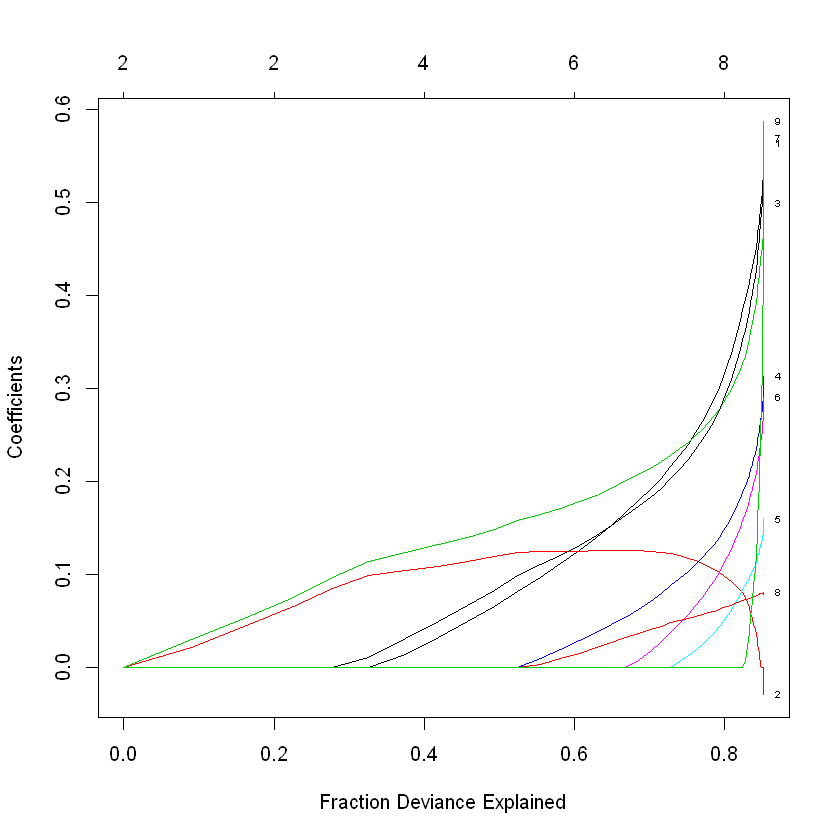

In [103]:
plot(fit, xvar = "dev", label = TRUE)

In [105]:
coef(cvfit, s = "lambda.min")
# the coefficients of the final model -- all are included

10 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  -6.963593696
thickness     0.395276703
uni_size      0.075872494
uni_shape     0.334610142
adhesion      0.194572592
epi_size      0.088621464
bare_nuclei   0.165565767
bland_chroma  0.362367057
normal_nuc    0.072941181
mitosis       0.007219468

In [108]:
pred <- predict(cvfit, x_matrix, s = "lambda.min", type = "class") 
actual_values <- breast_cancer$class
conf_matrix <- table(pred,actual_values)
conf_matrix

    actual_values
pred   0   1
   0 446  13
   1  12 228

In [61]:
CAD <- read.csv("Z-Alizadeh _sani_dataset.csv")
#summary(CAD)
#dim(CAD)

# remove non-numeric variables for correlation plot
numeric_CAD <- CAD[,-4] 
numeric_CAD <- numeric_CAD[, -c(10:16)]
numeric_CAD <- numeric_CAD[, -c(13:16)]
numeric_CAD <- numeric_CAD[, -14]
numeric_CAD <- numeric_CAD[, -c(15:18)]
numeric_CAD <- numeric_CAD[, -c(19:21)]
numeric_CAD <- numeric_CAD[, -c(35:36)]

# for glmnet
x_matrix_CAD <- model.matrix( ~ Age + Weight + Length + Sex + BMI + DM + HTN 
                + Current.Smoker + EX.Smoker + FH + Obesity + CRF + CVA + Airway.disease 
                + Thyroid.Disease + CHF + DLP + BP + PR + Edema + Weak.Peripheral.Pulse 
                + Lung.rales + Systolic.Murmur + Diastolic.Murmur + Typical.Chest.Pain
                + Dyspnea + Function.Class + Atypical + Nonanginal #+ Exertional.CP - everything is uniform
                + LowTH.Ang + Q.Wave+ St.Elevation + St.Depression + Tinversion
                + LVH + Poor.R.Progression + BBB + FBS + CR + TG + LDL + HDL + BUN 
                + ESR + HB + K + Na + WBC + Lymph + Neut + PLT + EF.TTE + Region.RWMA + VHD - 1 
                , CAD)
y_CAD <- CAD$Cath

[1] 303  34

      Age           Weight           Length           BMI       
 Min.   :30.0   Min.   : 48.00   Min.   :140.0   Min.   :18.12  
 1st Qu.:51.0   1st Qu.: 65.00   1st Qu.:158.0   1st Qu.:24.51  
 Median :58.0   Median : 74.00   Median :165.0   Median :26.78  
 Mean   :58.9   Mean   : 73.83   Mean   :164.7   Mean   :27.25  
 3rd Qu.:66.0   3rd Qu.: 81.00   3rd Qu.:171.0   3rd Qu.:29.41  
 Max.   :86.0   Max.   :120.00   Max.   :188.0   Max.   :40.90  
       DM             HTN         Current.Smoker     EX.Smoker    
 Min.   :0.000   Min.   :0.0000   Min.   :0.0000   Min.   :0.000  
 1st Qu.:0.000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.000  
 Median :0.000   Median :1.0000   Median :0.0000   Median :0.000  
 Mean   :0.297   Mean   :0.5908   Mean   :0.2079   Mean   :0.033  
 3rd Qu.:1.000   3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:0.000  
 Max.   :1.000   Max.   :1.0000   Max.   :1.0000   Max.   :1.000  
       FH               BP              PR             Edema       
 Min.   

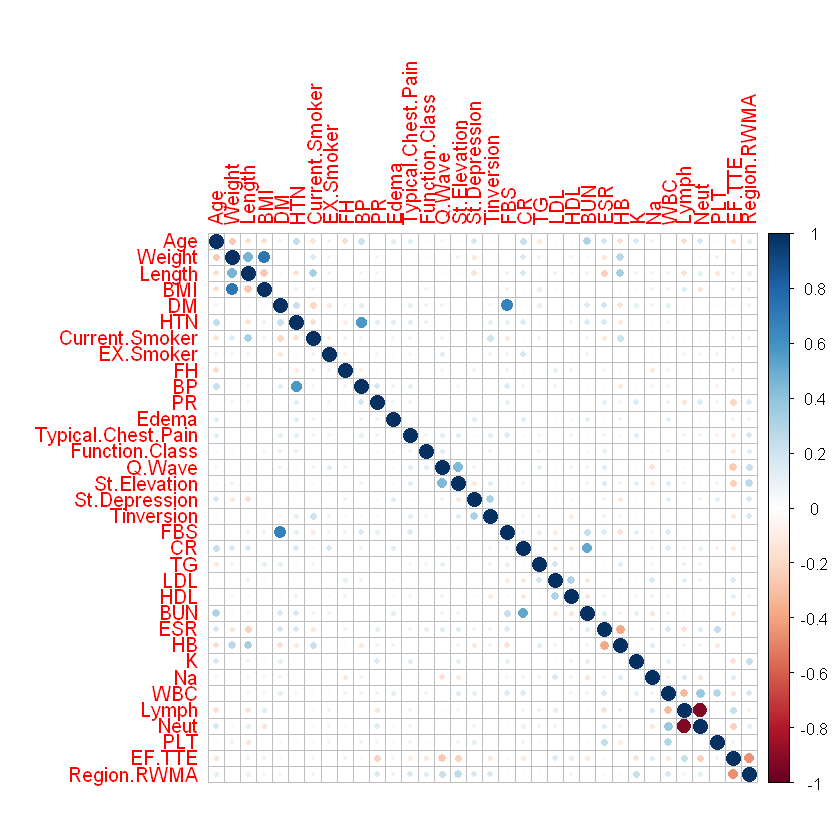

In [62]:
# CAD corrplot
correlations <- cor(numeric_CAD)
corrplot(correlations, method="circle")

In [83]:
# Logistic Regression
logistic_cad <- glm(Cath ~ Age + Weight + Length + Sex + BMI + DM + HTN 
                + Current.Smoker + EX.Smoker + FH + Obesity + CRF + CVA + Airway.disease 
                + Thyroid.Disease + CHF + DLP + BP + PR + Edema + Weak.Peripheral.Pulse 
                + Lung.rales + Systolic.Murmur + Diastolic.Murmur + Typical.Chest.Pain
                + Dyspnea + Function.Class + Atypical + Nonanginal #+ Exertional.CP - everything is uniform
                + LowTH.Ang + Q.Wave+ St.Elevation + St.Depression + Tinversion
                + LVH + Poor.R.Progression + BBB + FBS + CR + TG + LDL + HDL + BUN 
                + ESR + HB + K + Na + WBC + Lymph + Neut + PLT + EF.TTE + Region.RWMA + VHD
                , data = CAD, family=binomial(link='logit'))

summary(logistic_cad)

#anova(logistic_cad, test="Chisq")

threshold = 0.5
fitted.results <- predict(logistic_cad,type='response')
fitted.results <- ifelse(fitted.results > threshold,1,0)

#misclassification error
#misClassificError <- mean(fitted.results != CAD$Cath)
#misClassificError

# confusion matrix
predicted_values <- ifelse(predict(logistic_cad,type="response") > threshold,1,0)
actual_values <- CAD$Cath
conf_matrix <- table(predicted_values,actual_values)
conf_matrix



#sensitivity(conf_matrix)
#specificity(conf_matrix)


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = Cath ~ Age + Weight + Length + Sex + BMI + DM + 
    HTN + Current.Smoker + EX.Smoker + FH + Obesity + CRF + CVA + 
    Airway.disease + Thyroid.Disease + CHF + DLP + BP + PR + 
    Edema + Weak.Peripheral.Pulse + Lung.rales + Systolic.Murmur + 
    Diastolic.Murmur + Typical.Chest.Pain + Dyspnea + Function.Class + 
    Atypical + Nonanginal + LowTH.Ang + Q.Wave + St.Elevation + 
    St.Depression + Tinversion + LVH + Poor.R.Progression + BBB + 
    FBS + CR + TG + LDL + HDL + BUN + ESR + HB + K + Na + WBC + 
    Lymph + Neut + PLT + EF.TTE + Region.RWMA + VHD, family = binomial(link = "logit"), 
    data = CAD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1941  -0.0191  -0.0002   0.0078   2.6880  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)   
(Intercept)            -8.599e+01  5.480e+01  -1.569  0.11657   
Age                    -1.609e-01  5.278e-02  -3.048  0.00230 **
Weight                 -7.666e-01  

                actual_values
predicted_values Cad Normal
               0 207      6
               1   9     81

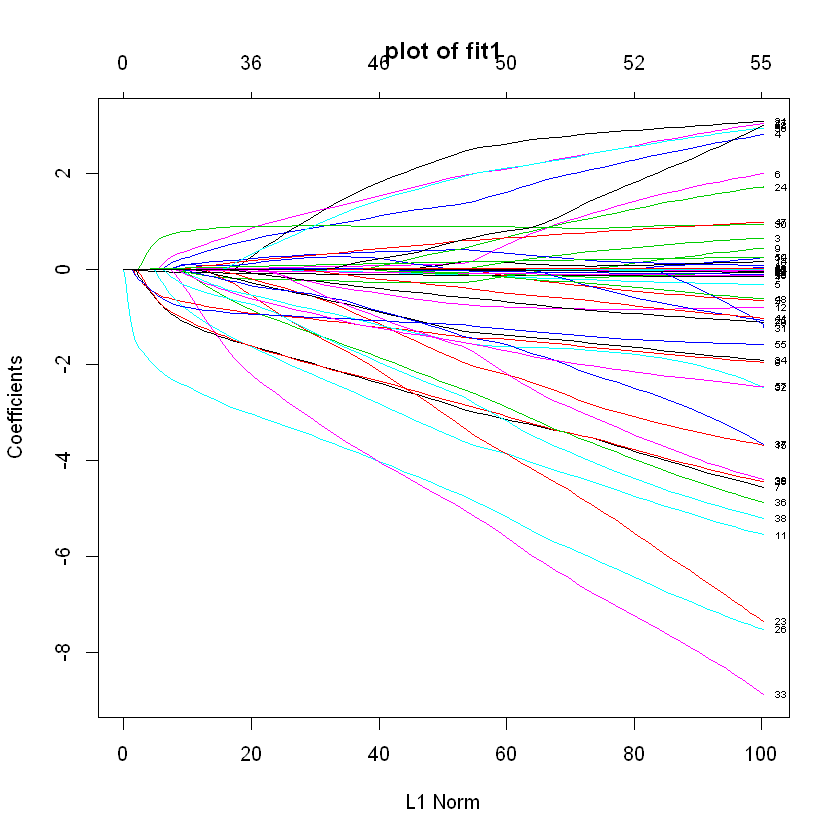

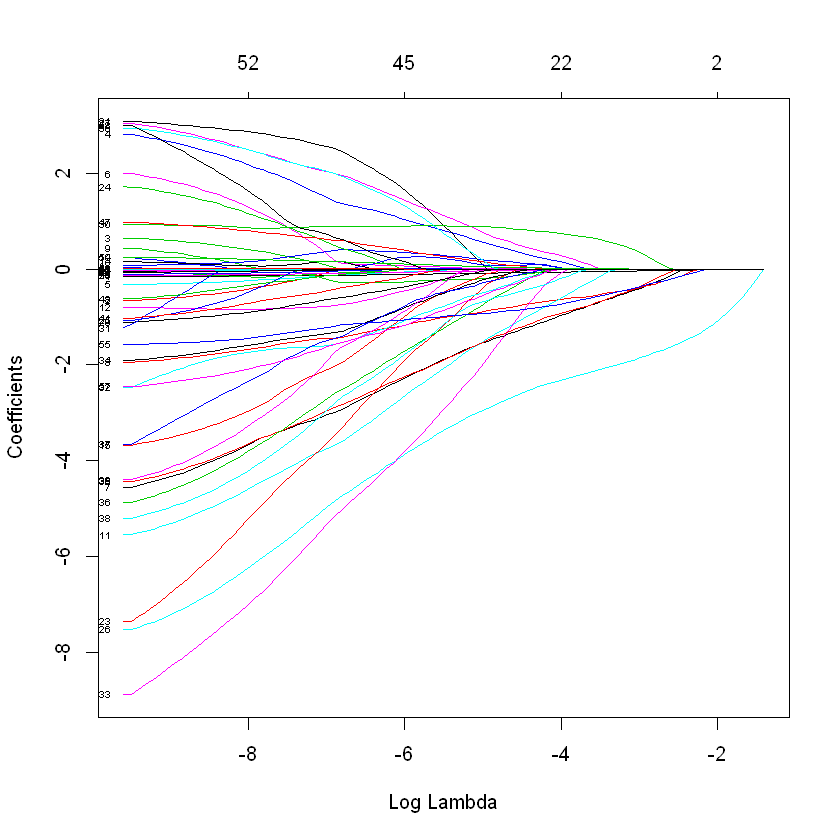

In [95]:
#sparse logistic
# The input must be a matrix, not a data frame
fit = glmnet(x_matrix_CAD, y_CAD, family="binomial")
#plot(fit, main="plot of fit1", label=TRUE)
#coef(fit)
plot(fit, xvar = "lambda", label = TRUE)

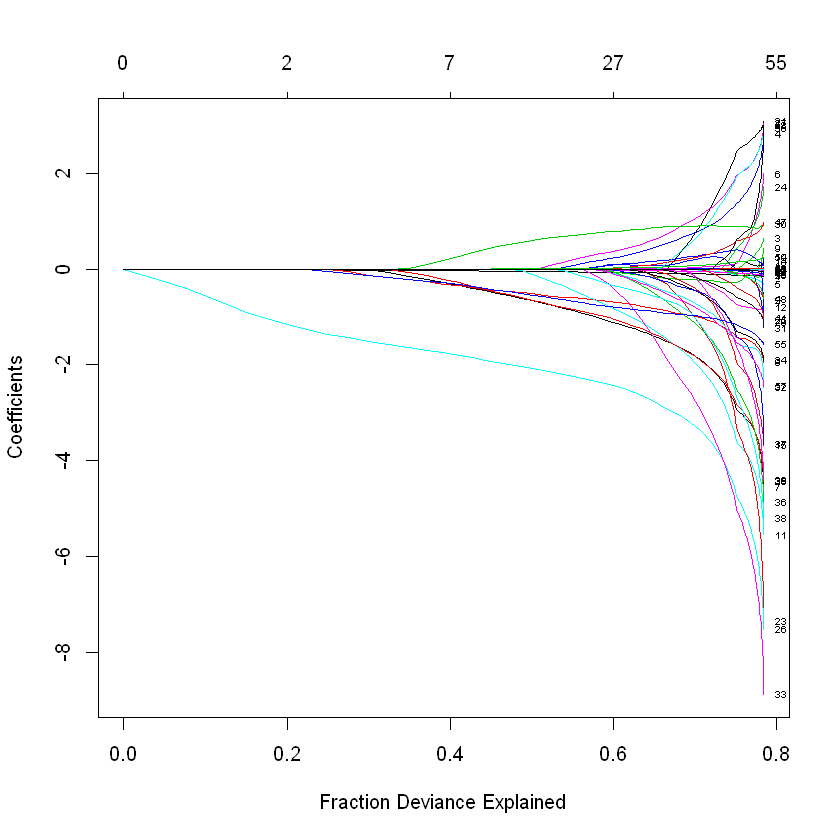

In [25]:
plot(fit, xvar = "dev", label = TRUE)

Warning message in plot.window(...):
""label" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""label" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""label" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""label" is not a graphical parameter"Warning message in box(...):
""label" is not a graphical parameter"Warning message in title(...):
""label" is not a graphical parameter"

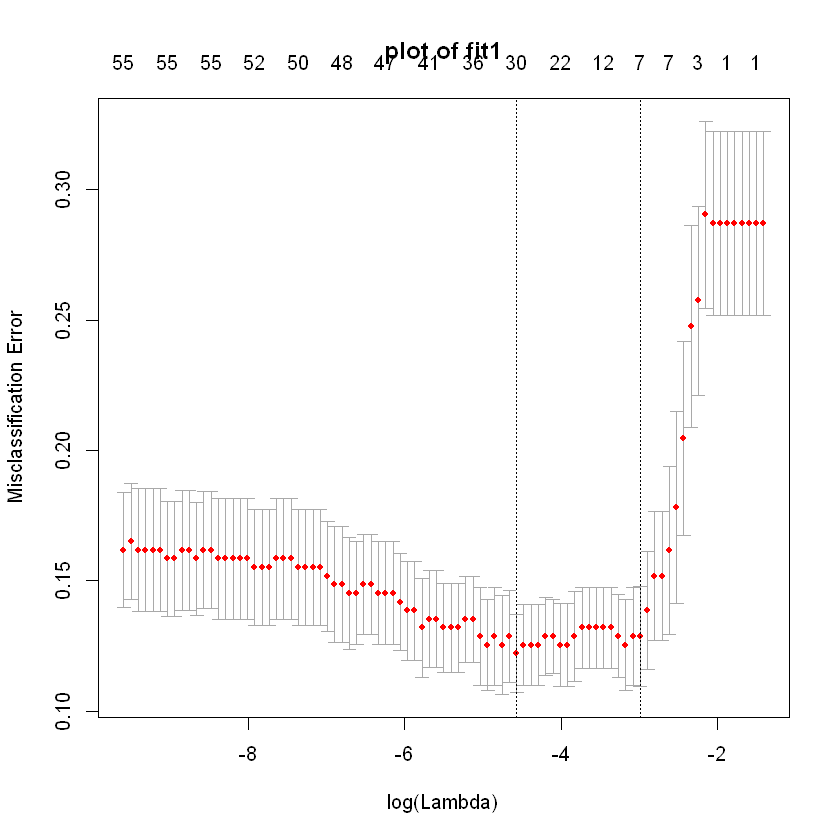

In [96]:
cvfit = cv.glmnet(x_matrix_CAD, y_CAD, family = "binomial", type.measure = "class")
# response” gives the fitted probabilities
# class” produces the class label corresponding to the maximum probability.
# “coefficients” computes the coefficients at values of s
# “nonzero” returns a list of the indices of the nonzero coefficients for each value of s.
#cvfit
plot(cvfit, main="plot of Cross Validation Fit", label=TRUE)

In [86]:
coef(cvfit, s = "lambda.min")

59 x 1 sparse Matrix of class "dgCMatrix"
                                   1
(Intercept)             7.2593974263
Age                    -0.0671572383
Weight                  .           
Length                  .           
SexFmale                0.1866604747
SexMale                -0.0005149982
BMI                     .           
DM                     -1.0316457118
HTN                    -0.6591846479
Current.Smoker         -0.0352592603
EX.Smoker               .           
FH                     -0.7008985497
ObesityY                .           
CRFY                    .           
CVAY                    .           
Airway.diseaseY         .           
Thyroid.DiseaseY        .           
CHFY                    .           
DLPY                    0.0435438811
BP                     -0.0067954374
PR                     -0.0199723004
Edema                   .           
Weak.Peripheral.PulseY  .           
Lung.ralesY             .           
Systolic.MurmurY        .        

In [94]:
# predict classes, make confusion matrix
pred <- predict(cvfit, x_matrix_CAD, s = "lambda.min", type = "class") 
actual_values <- CAD$Cath
conf_matrix <- table(pred,actual_values)
conf_matrix
#the matrix is worse than for logistic regression

        actual_values
pred     Cad Normal
  Cad    205     18
  Normal  11     69